In [1]:
import os
import cv2
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import joblib

In [2]:
import data_processing as dp

#img_size = 64
#color_mode = 'grayscale'
#max_image_per_class = 500

(X_train, X_test, y_train, y_test), reverse_map = dp.load_asl_alphabet_dataset(64, 'grayscale', 500)

In [3]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [4]:
svm_model = SVC(kernel='rbf', C=5, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

svm_train_preds = svm_model.predict(X_train_scaled)
svm_test_preds = svm_model.predict(X_test_scaled)

svm_train_acc = accuracy_score(y_train, svm_train_preds)
svm_test_acc = accuracy_score(y_test, svm_test_preds)

print("SVM Train Accuracy:", svm_train_acc)
print("SVM Test Accuracy:", svm_test_acc)

# Save SVM model
joblib.dump(svm_model, "./model/svm_model.pkl")

SVM Train Accuracy: 0.983103448275862
SVM Test Accuracy: 0.9506896551724138


['./model/svm_model.pkl']

In [5]:

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

knn_train_preds = knn_model.predict(X_train_scaled)
knn_test_preds = knn_model.predict(X_test_scaled)

knn_train_acc = accuracy_score(y_train, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)

print("KNN Train Accuracy:", knn_train_acc)
print("KNN Test Accuracy:", knn_test_acc)

# Save KNN model
joblib.dump(knn_model, "./model/knn_model.pkl")

KNN Train Accuracy: 0.9818965517241379
KNN Test Accuracy: 0.9324137931034483


['./model/knn_model.pkl']

In [6]:
# Classification Reports ----------
#print("\n📊 Classification Report - SVM")
#print(classification_report(y_test, svm_preds, target_names=[reverse_map[i] for i in range(len(reverse_map))]))

#print("\n📊 Classification Report - KNN")
#print(classification_report(y_test, knn_preds, target_names=[reverse_map[i] for i in range(len(reverse_map))]))

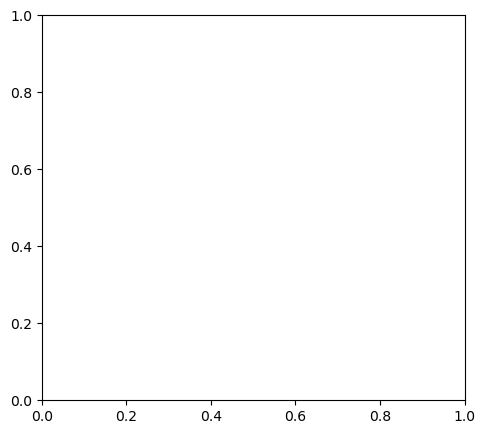

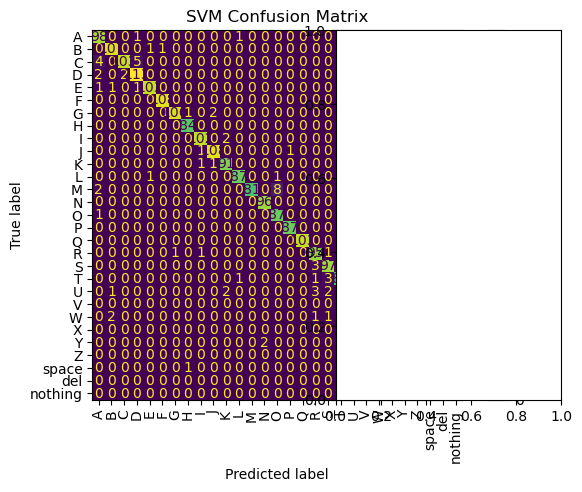

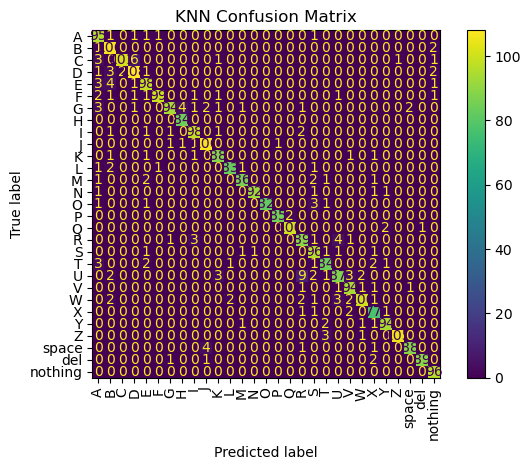

In [8]:
# Predict with SVM
svm_preds = svm_model.predict(X_test_scaled)

# Predict with KNN
knn_preds = knn_model.predict(X_test_scaled)

cm_svm = confusion_matrix(y_test, svm_preds)
cm_knn = confusion_matrix(y_test, knn_preds)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ConfusionMatrixDisplay(cm_svm, display_labels=[reverse_map[i] for i in range(len(reverse_map))]).plot(xticks_rotation='vertical')
plt.title("SVM Confusion Matrix")
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay(cm_knn, display_labels=[reverse_map[i] for i in range(len(reverse_map))]).plot(xticks_rotation='vertical')
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()

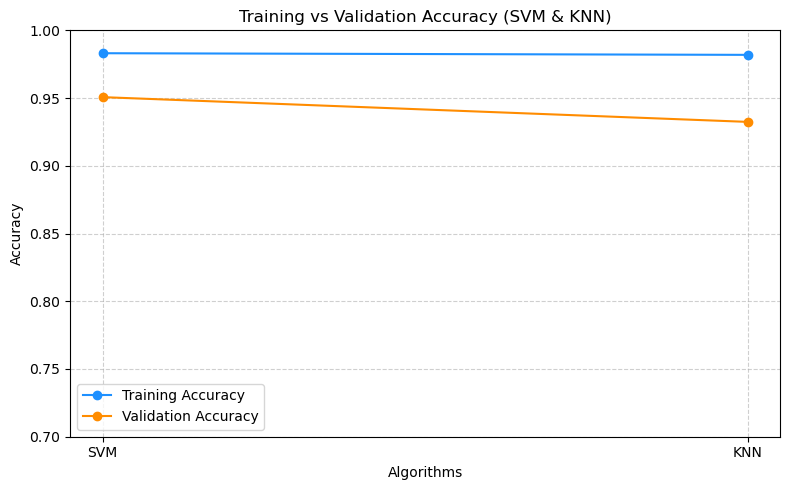

In [9]:

algorithms = ['SVM', 'KNN']
train_accuracy = [svm_train_acc, knn_train_acc]
test_accuracy = [svm_test_acc, knn_test_acc]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(algorithms, train_accuracy, 'o-', label='Training Accuracy', color='dodgerblue')
plt.plot(algorithms, test_accuracy, 'o-', label='Validation Accuracy', color='darkorange')

plt.title('Training vs Validation Accuracy (SVM & KNN)')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

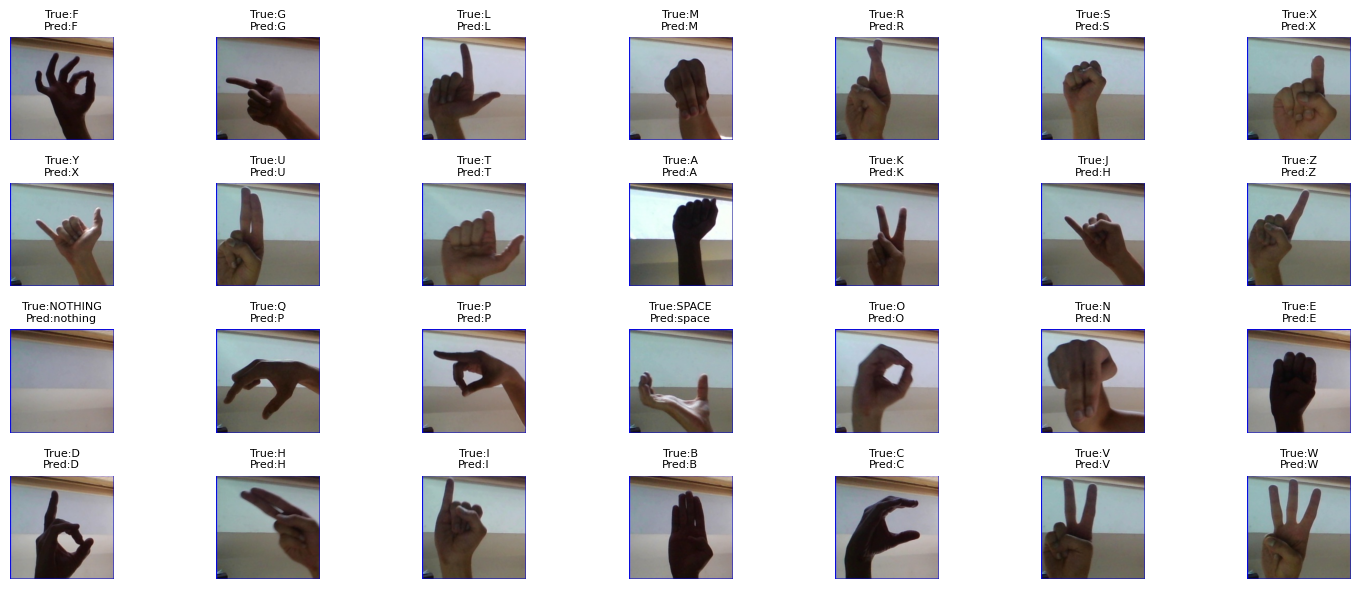

In [15]:
def evaluate_svm_on_test_folder(svm_model, scaler, test_dir, img_size, reverse_map):
    results = []
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype("float32") / 255.0
        img_flat = img.reshape(1, -1)
        img_scaled = scaler.transform(img_flat)

        pred_class = svm_model.predict(img_scaled)[0]
        pred_label = reverse_map[pred_class]

        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })

    # Plot predictions
    plt.figure(figsize=(15, 6))
    for i, (true_label, img_path) in enumerate(all_files):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 7, i + 1)
        plt.imshow(img)
        plt.title(f"True:{results[i]['True Label']}\nPred:{results[i]['Predicted Label']}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    return results

test_dir = "./data/asl_alphabet_test"
results_svm = evaluate_svm_on_test_folder(svm_model, scaler, test_dir, img_size=64, reverse_map=reverse_map)

In [16]:
 # Compute accuracy
correct = sum(1 for r in results_svm if r["True Label"] == r["Predicted Label"])
acc = correct / len(results_svm) if results_svm else 0
print(f"SVM Test accuracy: {acc:.4f}")

SVM Test accuracy: 0.8214


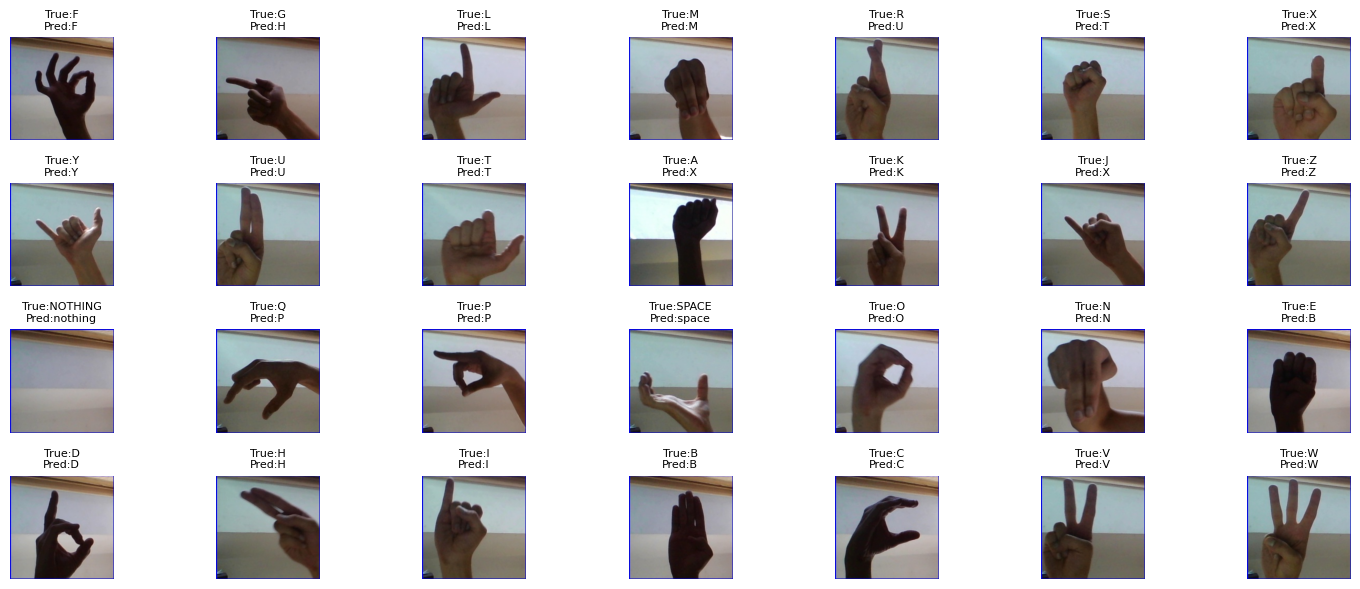

In [17]:
def evaluate_knn_on_test_folder(svm_model, scaler, test_dir, img_size, reverse_map):
    results = []
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype("float32") / 255.0
        img_flat = img.reshape(1, -1)
        img_scaled = scaler.transform(img_flat)

        pred_class = knn_model.predict(img_scaled)[0]
        pred_label = reverse_map[pred_class]

        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })

    # Plot predictions
    plt.figure(figsize=(15, 6))
    for i, (true_label, img_path) in enumerate(all_files):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 7, i + 1)
        plt.imshow(img)
        plt.title(f"True:{results[i]['True Label']}\nPred:{results[i]['Predicted Label']}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    return results

test_dir = "./data/asl_alphabet_test"
results_knn = evaluate_knn_on_test_folder(knn_model, scaler, test_dir, img_size=64, reverse_map=reverse_map)

In [18]:
 # Compute accuracy
correct = sum(1 for r in results_knn if r["True Label"] == r["Predicted Label"])
acc = correct / len(results_knn) if results_knn else 0
print(f"KNN Test accuracy: {acc:.4f}")

KNN Test accuracy: 0.6786
